In [3]:
import cv2
import numpy as np
from paddleocr import PaddleOCR
import re
import time
from collections import Counter
import base64

# 初始化 PaddleOCR
ocr_reader = PaddleOCR(
    use_textline_orientation=True,
    lang="en",
    text_detection_model_name="PP-OCRv5_mobile_det",
    text_recognition_model_name="PP-OCRv5_mobile_rec",
    text_detection_model_dir=r".\PP-OCRv5_mobile_det",
    text_recognition_model_dir=r".\PP-OCRv5_mobile_rec",
)
def order_points(pts):
    rect = np.zeros((4, 2), dtype="float32")
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect

def four_point_transform(image, pts):
    rect = order_points(pts)
    (tl, tr, br, bl) = rect
    widthA = np.linalg.norm(br - bl)
    widthB = np.linalg.norm(tr - tl)
    maxWidth = int(max(widthA, widthB))
    heightA = np.linalg.norm(tr - br)
    heightB = np.linalg.norm(tl - bl)
    maxHeight = int(max(heightA, heightB))
    if maxWidth <= 0 or maxHeight <= 0:
        return None
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype="float32")
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    return warped


def load_reference_image(ref_path):
    """載入標準答案圖片並記錄字串位置"""
    try:
        print(f"Loading reference from: {ref_path}")
        ref_image = cv2.imread(ref_path)
        if ref_image is None:
            print(f"❌ Cannot load reference image: {ref_path}")
            return None, []
        
        print(f"✅ Image loaded successfully, size: {ref_image.shape}")
        
        # 找標準答案的矩形並做透視變換
        ref_gray = cv2.cvtColor(ref_image, cv2.COLOR_BGR2GRAY)
        blur = cv2.GaussianBlur(ref_gray, (5, 5), 0)
        edges = cv2.Canny(blur, 50, 150)
        contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        print(f"Found {len(contours)} contours")

        max_area = 0
        best_approx = None
        valid_rectangles = 0
        
        for i, cnt in enumerate(contours):
            peri = cv2.arcLength(cnt, True)
            approx = cv2.approxPolyDP(cnt, 0.02 * peri, True)
            area = cv2.contourArea(approx)
            print(f"Contour {i}: vertices={len(approx)}, area={area:.0f}")
            
            if len(approx) == 4:
                valid_rectangles += 1
                print(f"  Valid rectangle {valid_rectangles}, area: {area}")
                if area > 5000:
                    print(f"  Area > 5000, considering...")
                    if area > max_area:
                        max_area = area
                        best_approx = approx.reshape(4, 2).astype(np.float32)
                        print(f"  NEW BEST: area={area}")

        print(f"Found {valid_rectangles} valid rectangles, max area: {max_area}")
        
        if best_approx is None:
            print("❌ Cannot find rectangle in reference image")
            return None, []

        print(f"✅ Rectangle found with area: {max_area}")
        print(f"Rectangle corners: {best_approx}")

        # 透視變換
        ref_warped = four_point_transform(ref_image, best_approx)
        if ref_warped is None:
            print("❌ Perspective transform failed")
            return None, []

        print(f"✅ Perspective transform successful, warped size: {ref_warped.shape}")
        # 可選：保存warped圖片用於debug
        cv2.imwrite("debug_ref_warped.jpg", ref_warped)
        print("Debug: Saved warped reference as 'debug_ref_warped.jpg'")

        # OCR標準答案
        print("Starting OCR on reference...")
        results = ocr_reader.predict(ref_warped)
        ref_positions = []
        
        print(f"OCR returned {len(results)} page(s)")
        for page_idx, page in enumerate(results):
            det_boxes = page.get('det_boxes', [])
            rec_texts = page.get('rec_texts', [])
            rec_scores = page.get('rec_scores', [])
            
            print(f"Page {page_idx}: {len(det_boxes)} detections")
            
            for i, (box, text, score) in enumerate(zip(det_boxes, rec_texts, rec_scores)):
                print(f"  Detection {i}: text='{text}', score={score:.3f}")
                
                if score >= conf_threshold:
                    clean_text = re.sub(r'[^A-Za-z0-9]', '', text)
                    if clean_text:
                        # 計算文字中心點和bounding box
                        pts = np.array(box, dtype=np.int32)
                        center_x = int(np.mean([point[0] for point in box]))
                        center_y = int(np.mean([point[1] for point in box]))
                        ref_positions.append((center_x, center_y, pts, clean_text))
                        print(f"    ✅ Added: '{clean_text}' at ({center_x}, {center_y})")
                    else:
                        print(f"    ❌ Rejected: clean_text is empty after filtering")
                else:
                    print(f"    ❌ Rejected: score {score:.3f} < {conf_threshold}")
        
        print(f"✅ Reference image loaded. Found {len(ref_positions)} text positions")
        return ref_warped, ref_positions
        
    except Exception as e:
        print(f"❌ Error loading reference image: {e}")
        import traceback
        traceback.print_exc()
        return None, []
    

C:\Users\ptril\AppData\Local\Temp\ipykernel_14228\3209499133.py:10: UserWarning: `lang` and `ocr_version` will be ignored when model names or model directories are not `None`.
  ocr_reader = PaddleOCR(
Creating model: ('PP-LCNet_x1_0_doc_ori', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\ptril\.paddlex\official_models\PP-LCNet_x1_0_doc_ori`.
Creating model: ('UVDoc', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\ptril\.paddlex\official_models\UVDoc`.
Creating model: ('PP-LCNet_x1_0_textline_ori', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\ptril\.paddlex\official_models\PP-LCNet_x1_0_textline_ori`.
Creating model: ('PP-OCRv5_mobile_det', '.\\PP-OCRv5_mobile_det')
Creating model: ('PP-OCRv5_mobile_rec', '.\\PP-OCRv5_mobile_rec')


In [5]:
# 載入標準答案
reference_image_path = r".\reference.JPG"  # 請修改為你的標準答案圖片路徑
reference_warped, reference_positions = load_reference_image(reference_image_path)
conf_threshold = 0.5

# Debug: 顯示載入的標準答案資訊
print(f"Reference positions loaded: {len(reference_positions)}")
for i, pos in enumerate(reference_positions):
    print(f"Ref {i}: center=({pos[0]}, {pos[1]}), text='{pos[3]}', bbox shape={len(pos[2])}")


Loading reference from: .\reference.JPG
✅ Image loaded successfully, size: (1034, 1845, 3)
Found 19 contours
Contour 0: vertices=4, area=156434
  Valid rectangle 1, area: 156434.5
  Area > 5000, considering...
  NEW BEST: area=156434.5
Contour 1: vertices=2, area=0
Contour 2: vertices=2, area=0
Contour 3: vertices=4, area=2
  Valid rectangle 2, area: 1.5
Contour 4: vertices=9, area=20
Contour 5: vertices=10, area=0
Contour 6: vertices=4, area=0
  Valid rectangle 3, area: 0.0
Contour 7: vertices=8, area=0
Contour 8: vertices=2, area=0
Contour 9: vertices=6, area=0
Contour 10: vertices=11, area=44
Contour 11: vertices=4, area=22
  Valid rectangle 4, area: 22.0
Contour 12: vertices=8, area=9
Contour 13: vertices=8, area=110
Contour 14: vertices=9, area=12
Contour 15: vertices=6, area=62
Contour 16: vertices=4, area=0
  Valid rectangle 5, area: 0.0
Contour 17: vertices=5, area=796
Contour 18: vertices=2, area=0
Found 5 valid rectangles, max area: 156434.5
✅ Rectangle found with area: 15643

In [40]:
def calculate_iou(box1, box2):
    """計算兩個矩形的IoU (Intersection over Union)"""
    # box格式: [x_min, y_min, x_max, y_max]
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])  
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    
    if x2 < x1 or y2 < y1:
        return 0.0
        
    intersection = (x2 - x1) * (y2 - y1)
    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union = area1 + area2 - intersection
    
    return intersection / union if union > 0 else 0.0

a =  [np.int16(63), np.int16(195), np.int16(242), np.int16(229)]
b = [np.int16(68), np.int16(174), np.int16(232), np.int16(204)]
calculate_iou(a,b)

np.float64(0.15487932843651628)

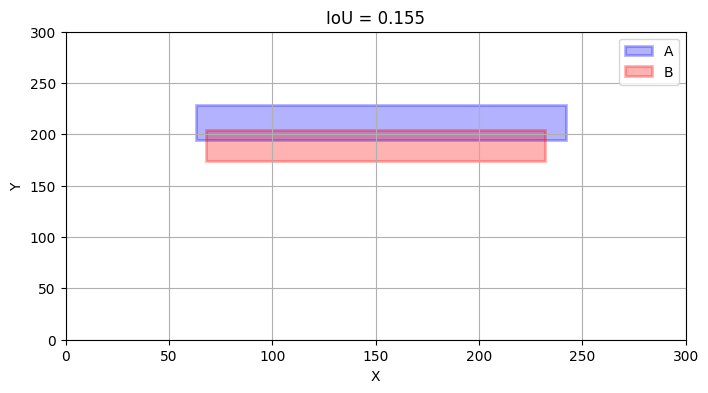

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
# 畫圖
fig, ax = plt.subplots(figsize=(8,4))

# 矩形A
rect_a = patches.Rectangle((a[0], a[1]), a[2]-a[0], a[3]-a[1],
                           linewidth=2, edgecolor='blue', facecolor='blue', alpha=0.3, label='A')
ax.add_patch(rect_a)

# 矩形B
rect_b = patches.Rectangle((b[0], b[1]), b[2]-b[0], b[3]-b[1],
                           linewidth=2, edgecolor='red', facecolor='red', alpha=0.3, label='B')
ax.add_patch(rect_b)

# 設置圖表
ax.set_xlim(0, 300)
ax.set_ylim(0, 300)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title(f'IoU = {calculate_iou(a,b):.3f}')
ax.legend()
plt.grid(True)
plt.show()
